In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, confusion_matrix

# Data Preprocessing

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#Eliminamos la primera columna, generada al pasar el conjunto de datos a formato csv.
train=train.drop(columns='Unnamed: 0')
test=test.drop(columns='Unnamed: 0')

train['proto'] = train['proto'].map({'TCP': 0, 'UDP': 1})
test['proto'] = test['proto'].map({'TCP': 0, 'UDP': 1})

In [6]:
# Grouping the variable push flag into 10 bins
bins = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = [i for i in range(len(bins)-1)]

train['ip.flags.df'] = pd.cut(train['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)
test['ip.flags.df'] = pd.cut(test['ip.flags.df'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.res'] = pd.cut(train['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.res'] = pd.cut(test['tcp.flags.res'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.cwr'] = pd.cut(train['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.cwr'] = pd.cut(test['tcp.flags.cwr'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.ecn'] = pd.cut(train['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.ecn'] = pd.cut(test['tcp.flags.ecn'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.urg'] = pd.cut(train['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.urg'] = pd.cut(test['tcp.flags.urg'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.ack'] = pd.cut(train['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.ack'] = pd.cut(test['tcp.flags.ack'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.reset'] = pd.cut(train['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.reset'] = pd.cut(test['tcp.flags.reset'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.syn'] = pd.cut(train['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.syn'] = pd.cut(test['tcp.flags.syn'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.push'] = pd.cut(train['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.push'] = pd.cut(test['tcp.flags.push'], bins=bins, labels=labels, right=True, include_lowest=True)

train['tcp.flags.fin'] = pd.cut(train['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)
test['tcp.flags.fin'] = pd.cut(test['tcp.flags.fin'], bins=bins, labels=labels, right=True, include_lowest=True)

In [6]:
train.groupby(['category', 'tcp.flags.syn']).size().reset_index(name='count')

/tmp/ipykernel_239230/3673978437.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  train.groupby(['category', 'tcp.flags.syn']).size().reset_index(name='count')


,category,tcp.flags.syn,count
0,Benign,0,81331
1,Benign,1,9062
2,Benign,2,17639
3,Benign,3,202
4,Benign,4,78
...,...,...,...
105,Recon-PortScan,6,2
106,Recon-PortScan,7,140
107,Recon-PortScan,8,10
108,Recon-PortScan,9,9


In [4]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test = pd.concat([test_reducido_udp, test_reducido_tcp])

In [7]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train = train.drop(columns=['category'])
y_train = train['category']

# Separar características y etiquetas para conjunto de entrenamiento
X_test = test.drop(columns=['category'])
y_test = test['category']

## Full-Feature Model Evaluation

In [6]:
column_names = X_train.columns

#Normalización del conjunto de datos reducido
norm = StandardScaler()

X_train = pd.DataFrame(norm.fit_transform(X_train), columns=column_names)
X_test = pd.DataFrame(norm.transform(X_test), columns=column_names)

In [9]:
X_train.shape, X_test.shape

((1119, 56), (320, 56))

In [8]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 50, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train, y_train)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'C': np.float64(34.1)}
Best Cross Validation Score: 0.6442785073670724
Test Score: 0.6625


In [13]:
SVM =  grid.best_estimator_
y_pred = SVM.predict(X_test)
print('Precision en test: ', accuracy_score(y_test, y_pred))

Precision en test:  0.6625


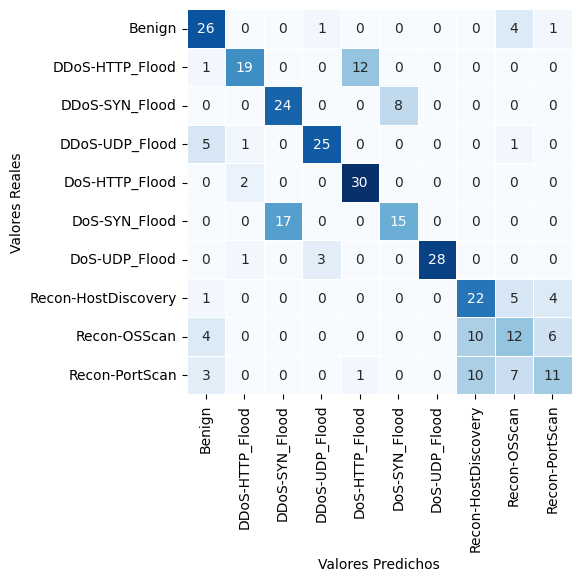

In [14]:
cm1 = confusion_matrix(y_test, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

# Dropping Constant and Quasi-constant features

## First method

We consider the feature as a quasi-constant feature, if the predominant value has more than X % of the observations

In [8]:
quasi_constant_feat = []

for feature in X_train.columns:
    
    predominant = X_train[feature].value_counts(normalize=True).values[0]
    
    # 
    if predominant > 0.998:
        quasi_constant_feat.append(feature)
        
len(quasi_constant_feat)
    

12

In [9]:
quasi_constant_feat

['ip.flags.rb',
 'ip.flags.mf',
 'tcp.flags.res',
 'tcp.flags.ns',
 'tcp.flags.cwr',
 'tcp.flags.ecn',
 'tcp.flags.urg',
 'ip.checksum.status.min',
 'l4.checksum.status.std',
 'l4.checksum.status.min',
 'l4.checksum.status.max',
 'l4.checksum.status.mean']

In [10]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

X_train.shape, X_test.shape

((1117830, 44), (319400, 44))

## Total samples per class: 111783

In [8]:
grouped_counts=train.groupby(['category', 'tcp.flags.push']).size().reset_index(name='count')
zero_counts = grouped_counts[grouped_counts['tcp.flags.push']!=0]
zero_counts

/tmp/ipykernel_240563/1546321388.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_counts=train.groupby(['category', 'tcp.flags.push']).size().reset_index(name='count')


,category,tcp.flags.push,count
1,Benign,1,1055
2,Benign,2,14764
3,Benign,3,3187
4,Benign,4,6163
5,Benign,5,1396
...,...,...,...
105,Recon-PortScan,6,112
106,Recon-PortScan,7,46
107,Recon-PortScan,8,3
108,Recon-PortScan,9,0


In [9]:
grouped_counts = train.groupby(['category', 'ip.checksum.status.std']).size().reset_index(name='count')
zero_counts = grouped_counts[grouped_counts['ip.checksum.status.std'] != 0]
category_counts = zero_counts.groupby('category')['count'].sum().reset_index(name='total_count')
category_counts

,category,total_count
0,Benign,5080
1,DDoS-HTTP_Flood,230
2,DDoS-SYN_Flood,5
3,DDoS-UDP_Flood,9229
4,DoS-HTTP_Flood,108
5,DoS-SYN_Flood,2
6,DoS-UDP_Flood,1300
7,Recon-HostDiscovery,159
8,Recon-OSScan,615
9,Recon-PortScan,497


## Second Method

We consider the feature as a quasi-constant feature if the variance of the feature is over 0.01

In [11]:
sel = VarianceThreshold(threshold=0.01)
sel.fit(X_train)

VarianceThreshold(threshold=0.01)

In [12]:
quasi_constant = X_train.columns[~sel.get_support()]

quasi_constant

Index(['ip.checksum.status.std', 'ip.checksum.status.max',
       'ip.checksum.status.mean'],
      dtype='object')

In [10]:
features = X_train.columns[sel.get_support()]

X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

X_train.shape, X_test.shape

((1117830, 41), (319400, 41))

## Dropping Duplicated Features

There aren't any 

In [15]:
sel = DropDuplicateFeatures(variables=None, missing_values='raise')
sel.fit(X_train)
sel.duplicated_feature_sets_

[]

# Correlated Features

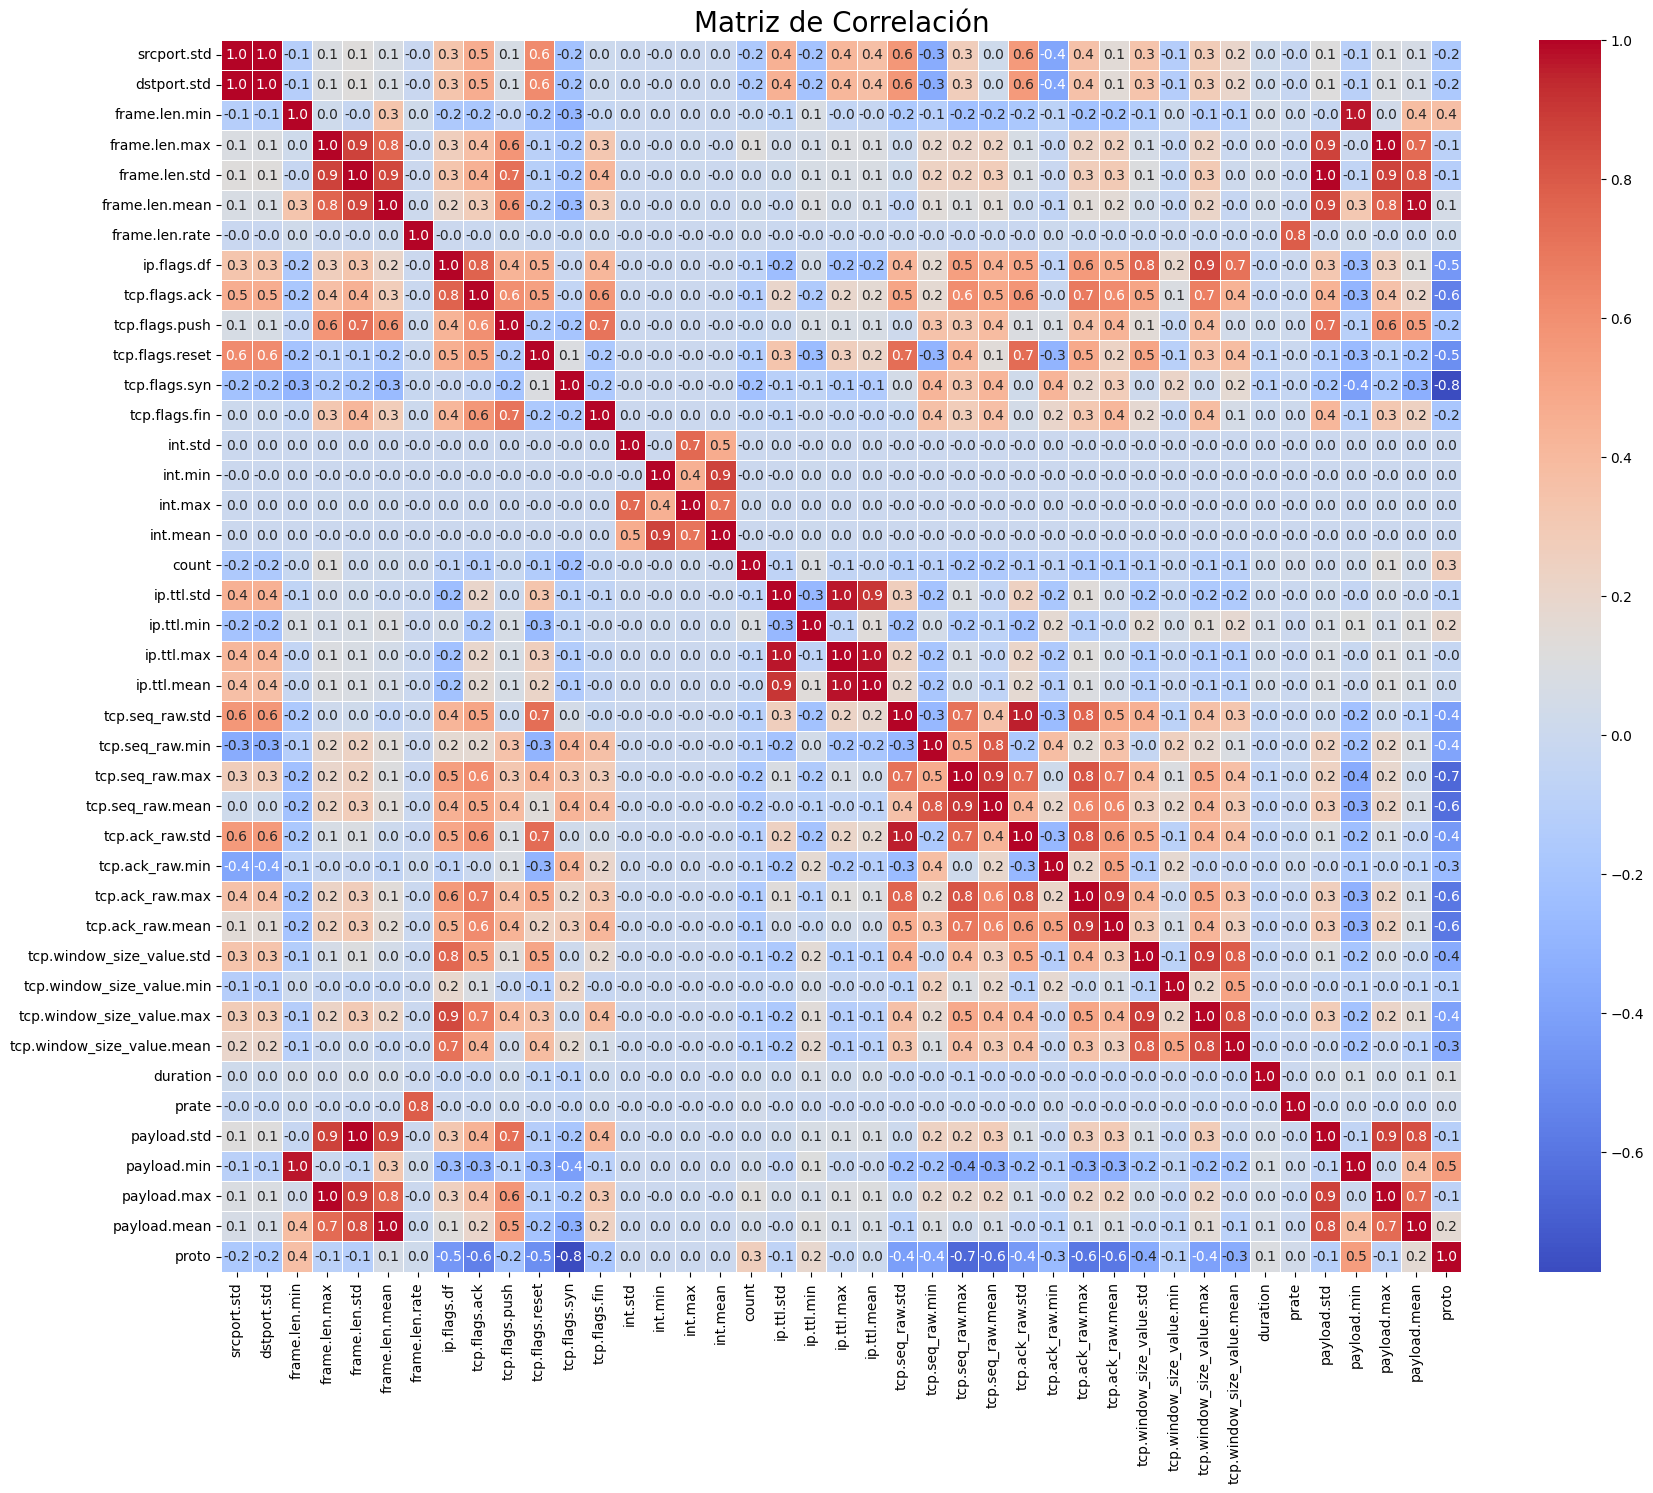

In [13]:
import numpy as np
corr_matrix = X_train.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".1f")
plt.title("Matriz de Correlación", fontsize=20)
plt.show()


In [15]:
c = 0

for i in corr_matrix.loc['ip.ttl.max']:
    if i > 0.85:
        print(corr_matrix.columns[c], i)
        
    c += 1

ip.ttl.std 0.9720460527354214
ip.ttl.max 1.0
ip.ttl.mean 0.9764186145265968


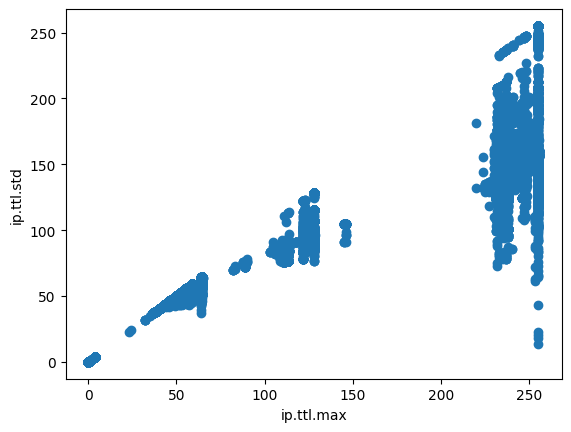

In [32]:
plt.scatter(X_train['ip.ttl.max'], X_train['ip.ttl.mean'])
plt.xlabel('ip.ttl.max')
plt.ylabel('ip.ttl.std')
plt.show()

In [33]:
c = 0

for i in corr_matrix.loc['proto']:
    if i < -0.75:
        print(corr_matrix.columns[c], i)
        
    c += 1

tcp.flags.syn -0.7625656736946304


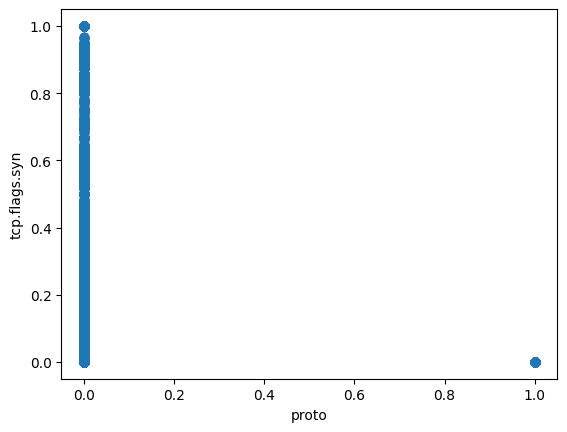

In [34]:
plt.scatter(X_train['proto'], X_train['tcp.flags.syn'])
plt.xlabel('proto')
plt.ylabel('tcp.flags.syn')
plt.show()

## Method 1 : Brute Force

In [12]:
def correlation(dataset, threshold):
    
    # create a set where I will store the names of correlated columns. Sets cannot contain duplicated elements
    col_corr = set()
    
    # create the correlation matrix
    corr_matrix = dataset.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corr_matrix.columns)):
        
        # check with other features (Not with itself)
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                
                # get the name of the correlated feature
                colname = corr_matrix.columns[j]
                
                # and add it to our correlated set
                col_corr.add(colname)
                
    return col_corr

In [22]:
corr_features = correlation(X_train, 0.90)
len(set(corr_features))

1.0 dstport.std srcport.std
0.9720460527354214 ip.ttl.max ip.ttl.std
0.9094681371010614 ip.ttl.mean ip.ttl.std
0.9764186145265968 ip.ttl.mean ip.ttl.max
0.9028231538344306 tcp.seq_raw.mean tcp.seq_raw.max
0.9532631167078506 tcp.ack_raw.std tcp.seq_raw.std
0.9124857948600464 tcp.ack_raw.mean tcp.ack_raw.max
0.9996532465954793 payload.std frame.len.std
0.9717974434019288 payload.min frame.len.min
0.9998232656437477 payload.max frame.len.max
0.992985277931503 payload.mean frame.len.mean


10

## We'll Drop the redundant features 

In [13]:
corr_features = ['srcport.std', 'ip.ttl.std','ip.ttl.mean', 'frame.len.mean', 'frame.len.max', 'frame.len.min', 'frame.len.std', 'tcp.ack_raw.std']

In [14]:
X_train.drop(labels=corr_features, axis=1, inplace=True)
X_test.drop(labels=corr_features, axis=1, inplace=True)

X_train.shape, X_test.shape

((1117830, 33), (319400, 33))

In [25]:
train = pd.concat([X_train, y_train], axis=1).to_csv('train_B.csv', index=False)
test = pd.concat([X_test, y_test], axis=1).to_csv('test_B.csv', index=False)

In [19]:
train = pd.read_csv("train_b.csv")
test = pd.read_csv("test_b.csv")

In [23]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [53]:
porcentaje_mantener = 0.001

train_reducido_udp = train[train['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
train_reducido_tcp = train[train['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

train_reducido = pd.concat([train_reducido_udp, train_reducido_tcp])


test_reducido_udp = test[test['proto'] == 1].groupby('category').sample(frac=porcentaje_mantener)
test_reducido_tcp = test[test['proto'] == 0].groupby('category').sample(frac=porcentaje_mantener)

test_reducido = pd.concat([test_reducido_udp, test_reducido_tcp])

In [54]:
# Separar características y etiquetas para conjunto de entrenamiento
X_train_reducido = train_reducido.drop(columns=['category'])
y_train_reducido = train_reducido['category']

# Separar características y etiquetas para conjunto de prueba
X_test_reducido = test_reducido.drop(columns=['category'])
y_test_reducido = test_reducido['category']

In [55]:
column_names = X_train_reducido.columns

In [56]:
#Normalización del conjunto de datos reducido
norm = StandardScaler()

X_train_reducido = pd.DataFrame(norm.fit_transform(X_train_reducido), columns=column_names)
X_test_reducido = pd.DataFrame(norm.transform(X_test_reducido), columns=column_names)



In [57]:
SVM = svm.SVC(kernel='rbf', gamma='scale')

param_grid = {'C': list(np.arange(0.1, 40, 1))}
grid = GridSearchCV(estimator=SVM, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)
grid.fit(X_train_reducido, y_train_reducido)

print('Best Parameters:', grid.best_params_)
print('Best Cross Validation Score:', grid.best_score_)
print('Test Score:', grid.score(X_test_reducido, y_test_reducido))


Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best Parameters: {'C': np.float64(36.1)}
Best Cross Validation Score: 0.6388813260730302
Test Score: 0.6625


In [58]:
SVM =  grid.best_estimator_
y_pred = SVM.predict(X_test_reducido)
print('Precision en test: ', accuracy_score(y_test_reducido, y_pred))

Precision en test:  0.6625


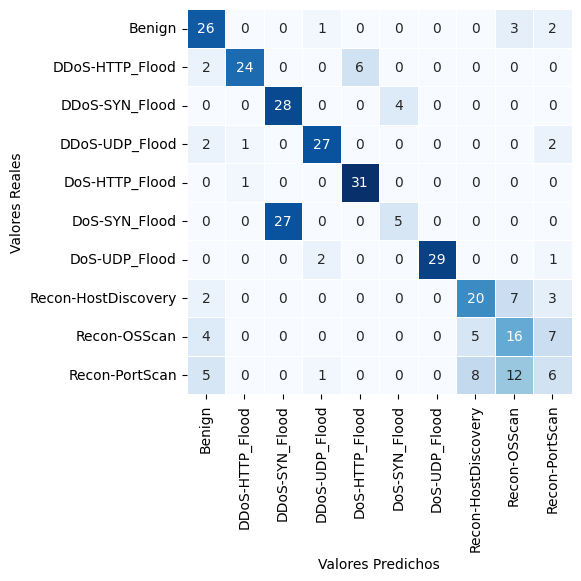

In [59]:
cm1 = confusion_matrix(y_test_reducido, y_pred)
normalized_matrix = cm1 #/ cm.sum(axis=1, keepdims=True)

class_names = ['Benign', 'DDoS-HTTP_Flood', 'DDoS-SYN_Flood', 'DDoS-UDP_Flood', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-UDP_Flood', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PortScan']

sns.heatmap(normalized_matrix, annot = True, fmt = '0.0f', linewidth=0.5, xticklabels=class_names,
            yticklabels=class_names, square = True, cmap='Blues', cbar = False)

fig = plt.gcf()
fig.set_size_inches(5, 5)

plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.show()

## Second Method

The second approach looks to identify groups of highly correlated features. And then, we can make further investigation within these groups to decide which feature we keep and which one we remove.

In [47]:
corrmat = X_train.corr()
corrmat = corrmat.abs().unstack() # absolute value of corr coef. Unsatck turns the index (features) into an additional column
corrmat = corrmat.sort_values(ascending=False) # sort by correlation
corrmat = corrmat[corrmat >= 0.8]
corrmat = corrmat[corrmat < 1]
corrmat = pd.DataFrame(corrmat).reset_index()
corrmat.columns = ['feature1', 'feature2', 'corr']
corrmat.head()

,feature1,feature2,corr
0,tcp.ack_raw.mean,tcp.ack_raw.max,0.912486
1,tcp.ack_raw.max,tcp.ack_raw.mean,0.912486
2,tcp.seq_raw.mean,tcp.seq_raw.max,0.902823
3,tcp.seq_raw.max,tcp.seq_raw.mean,0.902823
4,tcp.window_size_value.std,tcp.window_size_value.max,0.893685


In [26]:
corrmat[corrmat.feature1 == 'payload.max']

,feature1,feature2,corr
0,payload.max,frame.len.max,0.999823
27,payload.max,frame.len.std,0.873950
28,payload.max,payload.std,0.873936


In [51]:
# find groups of correlated features

grouped_feature_ls = []
correlated_groups = []

# iterate through the feature1 column in the table above
for feature in corrmat.feature1.unique():
    
    if feature not in grouped_feature_ls:

        # find all features correlated to a single feature. Each correlated black will have the feature that we're investigating in the first column
        # and all other features correlated to it in the second column
        correlated_block = corrmat[corrmat.feature1 == feature]
        # Now we add the investigated feature to the list of investigated features, this warrants that we don't investigate the same feature twice
        grouped_feature_ls = grouped_feature_ls + list(correlated_block.feature2.unique()) + [feature]

        # append the block of features to the list
        correlated_groups.append(correlated_block)

print('found {} correlated groups'.format(len(correlated_groups)))
print('out of {} total features'.format(X_train.shape[1]))


found 8 correlated groups
out of 33 total features


In [52]:
for group in correlated_groups:
    print(group)
    print()

           feature1         feature2      corr
0  tcp.ack_raw.mean  tcp.ack_raw.max  0.912486

           feature1         feature2      corr
2  tcp.seq_raw.mean  tcp.seq_raw.max  0.902823

                    feature1                   feature2      corr
4  tcp.window_size_value.std  tcp.window_size_value.max  0.893685

      feature1     feature2      corr
6  payload.max  payload.std  0.873936

  feature1  feature2      corr
8  int.min  int.mean  0.873486

       feature1                   feature2      corr
11  ip.flags.df  tcp.window_size_value.max  0.851083

                      feature1                   feature2      corr
12  tcp.window_size_value.mean  tcp.window_size_value.max  0.843338

        feature1     feature2      corr
14  payload.mean  payload.std  0.827318



### Now we need to evaluate groups 1 by 1

In [53]:
group = correlated_groups[0]
group

,feature1,feature2,corr
0,tcp.ack_raw.mean,tcp.ack_raw.max,0.912486


In [33]:
# add all features of the group to a list
features = list(group['feature2'].unique())+['payload.max']

# train a random forest 
rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=4)
rf.fit(X_train[features].fillna(0), y_train)

RandomForestClassifier(max_depth=4, n_estimators=200, random_state=39)

In [ ]:
importance = pd.concat(
    [pd.Series(features),
     pd.Series(rf.feature_importances_)], axis=1)

importance.columns = ['feature', 'importance']

# sort features by importance, most important first
importance.sort_values(by='importance', ascending=False)

,feature,importance
3,payload.max,0.502029
0,frame.len.max,0.276004
1,frame.len.std,0.185790
2,payload.std,0.036177
